# Self-Driving Car Nanodegree
# Vehicle Detection

In this project we will attempt to detect vehicles in a video frame. Once again we will be using classic computer vision techniques to extract features using Histogram of Oriented Gradients (HOG), train a linear support vector classifier, and then use sliding windows to apply the trained classifier to detect vehicles in an image.

In [133]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Dataset

Examples of vehicles and non-vehicles were collected from the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html) and the [KITTI vision benchmark](http://www.cvlibs.net/datasets/kitti/). The [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) collections should be downloaded and unzipped into this project directory.

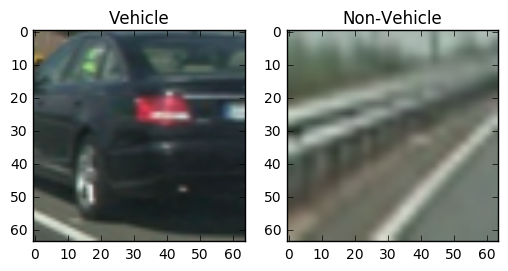

In [2]:
# Plot samples of vehicle and non-vehicle images.
example_vehicle = cv2.imread('vehicles/GTI_Right/image0000.png')
example_non_vehicle = cv2.imread('non-vehicles/GTI/image8.png')

fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(example_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Vehicle')
plt.subplot(122)
plt.imshow(cv2.cvtColor(example_non_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Non-Vehicle')

### Feature Extraction

The standard RGB colorspace used to display images on computer screens is not necessarily the best scheme to use for image recognition. For this project, we will instead use the YUV colorspace. The YUV colorspace proved to have the best classification accuracy among several that we tried (BGR, YUV, YCbCr, and HSV).

In [3]:
def colorTransform(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    return img

# Transform the example images to the YUV colorspace.
yuv_vehicle = colorTransform(example_vehicle)
yuv_non_vehicle = colorTransform(example_non_vehicle)

Now that the image has been loaded and converted to our preferred colorspace, we can extract the HOG features for each training image. Using the HOG features allows us to consider a fingerprint of the image that still allows some variability in the actual pixels.

Here we will bucket the HOG gradients into 8 buckets. Each image will be divided into cells of 8x8 pixels. The cells will be normalized into blocks of 2x2 cells. These values were chosen to balance the finding enough gradients to be able to identify a vehicle without making the dimensionality of the features too high. In particular, we note that classification accuracy continued to rise as the number of bins increased but this significantly increased the CPU and memory cost to deal with these additional features

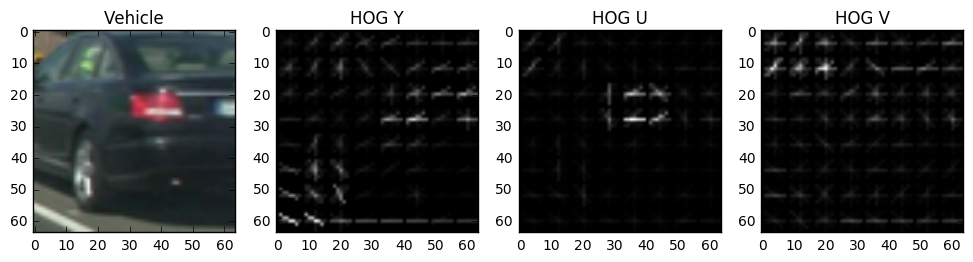

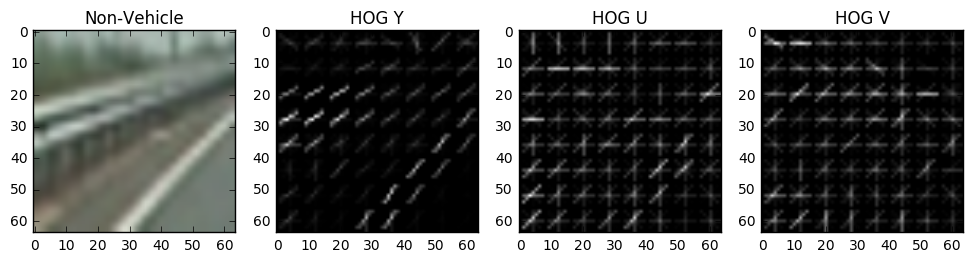

In [15]:
# HOG parameters
HOG_ORIENTATIONS = 8
HOG_PIXELS_PER_CELL = 8
HOG_CELLS_PER_BLOCK = 2

def hog_features(channel, visualise=False):
    if visualise == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(channel, orientations=HOG_ORIENTATIONS,
                                  pixels_per_cell=(HOG_PIXELS_PER_CELL, HOG_PIXELS_PER_CELL),
                                  cells_per_block=(HOG_CELLS_PER_BLOCK, HOG_CELLS_PER_BLOCK),
                                  transform_sqrt=False, visualise=True, feature_vector=False)
        return hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(channel, orientations=HOG_ORIENTATIONS,
                       pixels_per_cell=(HOG_PIXELS_PER_CELL, HOG_PIXELS_PER_CELL),
                       cells_per_block=(HOG_CELLS_PER_BLOCK, HOG_CELLS_PER_BLOCK),
                       transform_sqrt=False, visualise=False, feature_vector=True)
        return features

# Generate HOG visualization for example images.
hog_vehicle = [hog_features(yuv_vehicle[:,:,i], visualise=True) for i in range(3)]
hog_non_vehicle = [hog_features(yuv_non_vehicle[:,:,i], visualise=True) for i in range(3)]

fig = plt.figure(1, figsize=(12, 9))
plt.subplot(141)
plt.imshow(cv2.cvtColor(example_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Vehicle')
plt.subplot(142)
plt.imshow(hog_vehicle[0], cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_vehicle[1], cmap='gray')
plt.title('HOG U')
plt.subplot(144)
plt.imshow(hog_vehicle[2], cmap='gray')
plt.title('HOG V')
fig = plt.figure(2, figsize=(12,9))
plt.subplot(141)
plt.imshow(cv2.cvtColor(example_non_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Non-Vehicle')
plt.subplot(142)
plt.imshow(hog_non_vehicle[0], cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_non_vehicle[1], cmap='gray')
plt.title('HOG U')
plt.subplot(144)
plt.imshow(hog_non_vehicle[2], cmap='gray')
plt.title('HOG V')

We can now combine combine the individual transformations to extract a feature vector from an image. We experimented with using only a single channel to extract HOG features, but found that classification accuracy increased significantly by including all channels.

In [5]:
def extract_features(img):
    img = colorTransform(img)
    features_y = hog_features(img[:,:,0])
    features_u = hog_features(img[:,:,1])
    features_v = hog_features(img[:,:,2])
    return np.concatenate((features_y, features_u, features_v))

## Training the Classifier

Now that we have defined all of the helper functions to load images and extract features, we can create the feature vectors and categories from the training dataset.

In [6]:
X_all = []
y_all = []
for filename in glob.glob('vehicles/*/*.png'):
    img = cv2.imread(filename)
    features = extract_features(img)
    X_all.append(features)
    y_all.append(True)
for filename in glob.glob('non-vehicles/*/*.png'):
    img = cv2.imread(filename)
    features = extract_features(img)
    X_all.append(features)
    y_all.append(False)

Next we will normalize the feature vectors. This will help keep the classifier from erroneously focusing on features with values of different magnitudes. It will also improve the efficiency and numerical stability of the calculations by keeping the features values small and centered around zero.

We will also save the scaler to apply the same transformations to features extracted from images when we use the classifier to detect vehicles.

In [7]:
Xscaler = StandardScaler().fit(X_all)
X_all = Xscaler.transform(X_all)

Now we will split the extracted features and labels into a training set and a test set. The training set will be used train the classifier while the test set will be used to evaluate how well the classifier will generalize to unseen data. We will perform a stratified shuffled split, which should help ensure that the split randomly selects samples while roughly preserving the proportion of vehicle and non-vehicle examples. By explicitly setting the `random_state` parameter, we can make sure that the split will be repeatable as we develop the model.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=1)
X_all = None
y_all = None

With the examples now divided into a training set and a test set, we can now train the classifier. Once again, we will explicitly set the `random_state` parameter to ensure that the training results are reproduceable.

Here we have chosen to use a linear SVC classifier. This is a type of support vector machine classifier that has been optimized to work with linear kernels. The classifier will be trained using a concatenation of HOG features derived from each of the YUV channels of training images.

In [9]:
classifier = LinearSVC(random_state=1)
classifier.fit(X_train, y_train)

print('Vehicle classifier trained with test accuracy: %.1f%%' % (100. * classifier.score(X_test, y_test)))
X_train = None
X_test = None
y_train = None
y_test = None

Vehicle classifier trained with test accuracy: 98.5%


## Image Processing

Now that the classifier has been trained, we need to apply it to detect vehicles in our images. We will begin by creating a number of utility functions to process an image so that it may be used with the classifier.

### Bounding Boxes

First we will define a helper function to draw bounding boxes around regions of interest. This will help us visualise the image processing pipeline as we create it and will then be used to annotate the detected vehicles found in the image.

In [10]:
BBOX_COLOR = (0, 0, 255)
BBOX_THICKNESS = 6

# This assumes incoming image is encoded RGB.
def draw_boxes(img, bboxes):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], BBOX_COLOR, BBOX_THICKNESS)
    return imcopy

### Sliding Windows

To identify vehicles in an image, we will use a sliding windows approach to detect vehicles. The first step is to create a function that will return a list of windows that we will search through. Because we are only interested in detecting vehicles, we will limit the sliding windows to only search the bottom half of the image. We will also consider sliding windows of three different sizes to detect vehicles of various sizes in the image.

This initial implementation is fairly naive and doesn't take advantage of the image perspective. Because vehicles nearer to our car appear larger and vehicles farther away appear smaller, we could structure our sliding window generator significantly reduce the work by only considering windows of sizes we are likely to expect vehicles to be.

We chose not to use the obvious window sizes of powers of two so that the overlapping windows to be more staggered with respect to each other to try to catch vehicle features that didn't exactly line up with other window sizes.

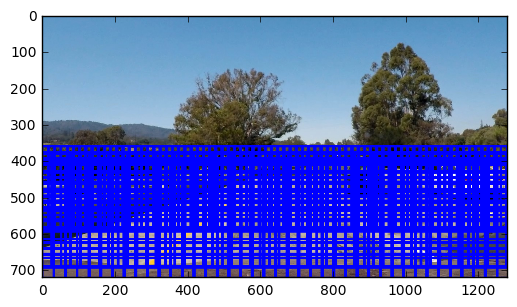

In [344]:
WINDOW_SIZES = [(70, 70), (105, 105), (130, 130)]
WINDOW_Y_START_STOP = [(360, 560), (380, 640), (400, 720)]
WINDOW_OVERLAP = (0.75, 0.75)

# This assumes incoming image is encoded RGB.
def sliding_windows(img):
    # Accumulate the list of windows to be searched.
    window_list = []
    
    # Process each window size.
    for (xy_window, y_start_stop) in zip(WINDOW_SIZES, WINDOW_Y_START_STOP):
        # Set the start and stop regions to scan.
        x_start = 0
        x_stop = img.shape[1]
        y_start = y_start_stop[0]
        y_stop = y_start_stop[1]
    
        # Compute the span of the region to be searched.
        xspan = x_stop - x_start
        yspan = y_stop - y_start
        
        # Compute the step between successive windows.
        nx_pix_per_step = np.int(xy_window[0] * (1. - WINDOW_OVERLAP[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1. - WINDOW_OVERLAP[1]))
        # Compute the number of windows to generate at this size.
        nx_windows = int(xspan/nx_pix_per_step) - 1
        ny_windows = int(yspan/ny_pix_per_step) - 1
        # Loop through the x and y positions to find the window coordinates.
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate the window position. Since we are more considered about
                # vehicles in our half of the road, start the windows from the lower
                # right and move up and to the left.
                startx = xs*nx_pix_per_step + x_start
                endx = startx + xy_window[0]
                starty = ys*nx_pix_per_step + y_start
                endy = starty + xy_window[1]
                # Append window position to the list.
                window_list.append(((startx, starty), (endx, endy)))
                
    # Return the list of windows.
    return window_list

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = sliding_windows(img)
img = draw_boxes(img, windows)
plt.imshow(img)

As shown in the image above, there are going to be a lot of windows that we will search. This is going to make detection computationally expensive. However, we noticed that reducing the overlap between frames of the different sizes of windows being searched had a negative impact in our ability to detect vehicles.

### Vehicle Detection in Sliding Windows

Now that we have generated a list of windows to search over, we can iterate through the list and run our classifier on each one. We will resize each window to 64x64 pixels to match the size our classifier was trained on. Then we can extract the HOG features for the resized image. The extracted features are then normalized using the scaler that was fit to the training data. Finally our classifier is asked to predict on the normalized features extracted for the window.

To reduce false positives, we will require that the detected vehicles pass a certain confidence threshold value, as measured by the classifier's decision function. Finding the right confidence threshold will have a significant affect on false positive and false negative rates.

Again, this implementation is still fairly naive. In the future, we could speed up detection by only generating HOG features once for the entire image and then subsampling those features for each sliding window we consider. This, however, is a speed optimization that won't necessarily improve the quality of the detections.

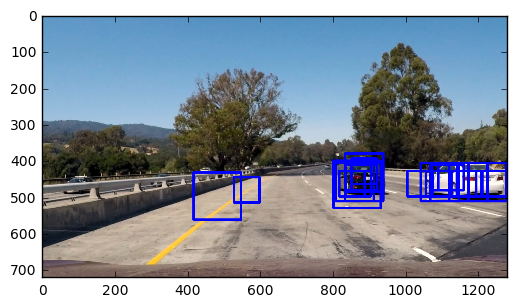

In [345]:
# Required confidence in prediction. A score greater than zero indicate a
# positive prediction.
CONFIDENCE_THRESHOLD = 0.8

def search_windows(img, windows, clf, scaler):
    # Create a list to hold the positive detections.
    on_windows = []
    
    # Iterate over all the windows in the list.
    for window in windows:
        # Extract the window image from the original image.
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Convert to the expected BGR in feature extractor.
        window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        # Extract features for the resized window image
        features = extract_features(window_img)
        # Normalize the extracted features.
        features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using the classifier.
        confidence = clf.decision_function(features)
        # Save the window if prediction is positive.
        if confidence > CONFIDENCE_THRESHOLD:
            on_windows.append(window)
    
    # Return the windows with positive detections.
    return on_windows

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = sliding_windows(img)
windows = search_windows(img, windows, classifier, Xscaler)
img = draw_boxes(img, windows)
plt.imshow(img)

Thresholding on the confidence of the sliding window prediction has helped eliminate many but not all false positives while still achieving multiple hits on the vehicles in our test images. With this high threshold, however, we miss occassionally detecting vehicles in video frames. Instead of reducing our threshold requirements, however, our plan will be to smooth out vehicle detection over several frames in the video.

In [346]:
# Loop through the test images and apply the sliding window detection.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    windows = sliding_windows(img)
    windows = search_windows(img, windows, classifier, Xscaler)
    img = draw_boxes(img, windows)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/sliding-window-' + filename, img)

### Heat Map

We can use the bounding boxes returned by the classifier as positive detections to add "heat" to certain portions of the image. If multiple windows detected the same car, then the heat map will show a strong amount of heat. Isolated false positives won't add much heat to the heat map, so we will be able to filter them out by setting a threshold for the amount of required heat that will be necessary to be considered a positive detection.

For our test images, the high confidence threshold we have set on the classifier has enabled us to acheive good detection without many false positives, and the heat map threshold filters out the remaining false positives. Unfortunately, we also filter out one of the vehicles. 

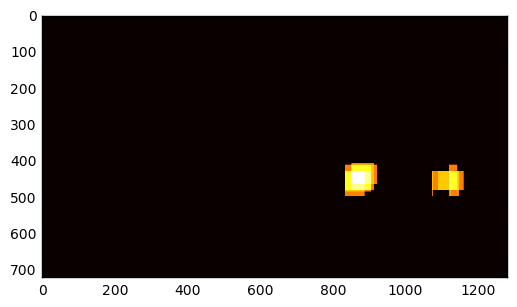

In [347]:
HEATMAP_THRESHOLD = 4

def add_heat(heatmap, bboxes):
    # Iterate through each bbox.
    for bbox in bboxes:
        # Add +1 for all pixels inside each bbox.
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    # Return updated heatmap.
    return heatmap
    
def apply_threshold(heatmap):
    # Zero out pixels below the threshold.
    heatmap[heatmap <= HEATMAP_THRESHOLD] = 0
    # Return thresholded map.
    return heatmap

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = sliding_windows(img)
windows = search_windows(img, windows, classifier, Xscaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)
plt.imshow(heatmap, cmap='hot')

### Labeling Vehicles

Once the heatmaps have been generated, we can try to identify the number of distinct vehicles within the image and draw a surrounding bounding box around each image. Here we will use SciPy's label function to fuse the heat map into distinct labeled regions. We can then construct bounding boxes around each detected vehicle which can be used to annotate the location of the vehicle in our image.

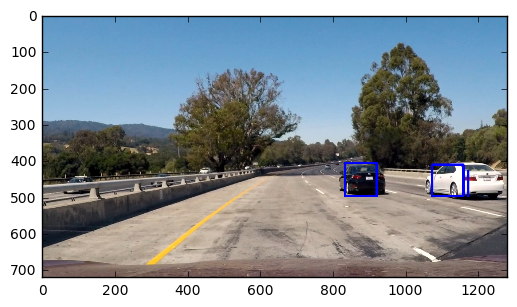

In [348]:
def draw_labeled_bboxes(img, heatmap):
    # Generate the labels from the heat map.
    labels = label(heatmap)
    # Keep a list of bboxes for detected vehicles.
    bboxes = []
    # Iterate through all detected vehicles.
    for vehicle in range(1, labels[1]+1):
        # Find pixels with each vehicle label value.
        nonzero = (labels[0] == vehicle).nonzero()
        # Identify x and y values of those pixels.
        nonzerox = np.array(nonzero[0])
        nonzeroy = np.array(nonzero[1])
        # Define a bounding box based on the min/max x and y.
        bbox = ((np.min(nonzeroy), np.min(nonzerox)), (np.max(nonzeroy), np.max(nonzerox)))
        bboxes.append(bbox)
    # Draw the bounding boxes for the detected vehicles.
    img = draw_boxes(img, bboxes)
    # Return the annotated image.
    return img

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = sliding_windows(img)
windows = search_windows(img, windows, classifier, Xscaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)
img = draw_labeled_bboxes(img, heatmap)
plt.imshow(img)

The labeling function has allowed us to neatly merge together the sliding windows with positive detections and draw a nice bounding box around the vehicles.

In [349]:
# Loop through the test images to label vehicle detection.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    windows = sliding_windows(img)
    windows = search_windows(img, windows, classifier, Xscaler)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, windows)
    heatmap = apply_threshold(heatmap)
    img = draw_labeled_bboxes(img, heatmap)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/label-' + filename, img)

### Smoothing Detections

To get better detection results as the video progresses, we will be collecting the bounding boxes of detected videos for each of the last few frames. All of the bounding boxes will then be added to a heat map, which will allow us to detect the recent locations of each vehicle. This will also allow us smooth over frames where we missed any detections.

In [342]:
# The number of frames to smooth over.
N_FRAMES = 10

class FrameData:
    def __init__(self):
        self.bboxes = []
    
    # Add bboxes for the new frame, keeping only N_FRAMES of data.
    def add_bboxes(self, bboxes):
        self.bboxes.append(bboxes)
        self.bboxes = self.bboxes[-N_FRAMES:]
    
    # Generate a heat map of detections for the last N_FRAMES of data.
    def heatmap(self):
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for bboxes in self.bboxes:
            add_heat(heatmap, bboxes)
        heatmap = apply_threshold(heatmap)
        return heatmap
    
def pipeline(img, frame_data=None):
    if frame_data is None:
        frame_data = FrameData()
    
    # Generate sliding windows for the image.
    windows = sliding_windows(img)
    # Search the sliding windows for vehicles
    windows = search_windows(img, windows, classifier, Xscaler)
    frame_data.add_bboxes(windows)
    # Get the heat map over the previous frames.
    heatmap = frame_data.heatmap()
    # Draw the labeled vehicle bounding boxes
    img = draw_labeled_bboxes(img, heatmap)
    # Return the processed image.
    return img    

## Video Pipeline

Now all the steps are in place to detect vehicles in the videos. For each video we create a new FrameData object that will be used to store recent classification results. This will allow us to improve results on the current frame by smoothing over imperfections with results from previous frames.

In [343]:
def process_image():
    frame_data = FrameData()
    return (lambda img: pipeline(img, frame_data=frame_data))

for filename in ['test_video.mp4', 'project_video.mp4']:
    clip = VideoFileClip(filename)
    out = clip.fl_image(process_image())
    out.write_videofile('processed-' + filename, audio=False)

[MoviePy] >>>> Building video processed-test_video.mp4
[MoviePy] Writing video processed-test_video.mp4


 97%|█████████▋| 38/39 [03:29<00:05,  5.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed-test_video.mp4 

[MoviePy] >>>> Building video processed-project_video.mp4
[MoviePy] Writing video processed-project_video.mp4


100%|█████████▉| 1260/1261 [1:51:02<00:05,  5.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed-project_video.mp4 



## Results

Additional code and results for this project can be found in the Jupyter notebook accompanying this project.

* ```CarND-Vehicle_Detection.ipynb```: Source project notebook.

The processed videos can be found in the main directory.

* ```processed-project_video.mp4```: The project video.
* ```processed-test_video.mp4```: A small extract of the project video used to test changes to the pipeline.

As can be seen from the videos above, the main project video is able to fairly track the presence and progress of nearby vehicles.

Intermediate progress images were saved as the pipeline was being developed. They can be examined to see the effects of different transformations in the pipeline. These images are stored in the ```output_images``` directory.

* ```sliding-window-*.jpg```: The test images after searching the overlapping sliding windows for vehicle detections. Windows where the classifier predicted a vehicle have been marked with a bounding box area the window.
* ```label-*.jpg```: The test images after the bounding boxes from the sliding windows search have been added to a heat map and then labeled as belonging to a specific vehicle. The heat map and labeling steps effectively merged the individual sliding window results into a single bounding box around each vehicle.

## Observations

While deep learning and convolutional neural networks are the currently fashionable solution to image classification problems, it was refreshing to see that traditional approaches like linear support vector classifiers are still able to be used as highly accurate classifiers. A transform to a more suitable colorspace and then an extraction of HOG features was enough to train the vehicle classifier to an accuracy in excess of 98.5%.

While training a high quality vehicle classifier was fairly straightforward, using it to detect vehicles in the project video was more challenging. Examining sliding windows in the images for vehicles, merging partial detections together, and tracking the progress of the vehicle from frame to frame required much more effort.

### Problems & Issues Faced

The biggest challenge faced was conducting an efficient search through a high resolution video image to detect the locations of other vehicles on the road. Effective parameter tuning was extremely important. Accepting low confidence classifications would lead to too many false positives, but setting the confidence threshold too high resulted in failures to correctly classify vehicles. Similarly, heat map thresholding could eliminate many false positives at the cost of also filtering out correct classifications.

In the end, we suffered from both of these problems. Our high filtering was not strong enough eliminate all of the false positives, but too strong to hold on to all of the correct classifications.

Once again, this project illustrated the high degree of manual parameter tuning that is required for effective feature engineering and classification with traditional computer vision techniques. Deep learning approaches should be able learn and adapt to changing features.

### Where the Pipeline Could Fail

There were several weak areas in the pipeline. While the pipeline was able to detect nearby vehicles as they passed our car, other vehicles further in the distance and on the opposite side of the road were rarely detected. This will unfortunately affect the safety of potential path planning strategies by not being able prepare for developing traffic situations.

The pipeline was not able to effectively separate vehicles that drove too near each other. Instead of cleanly annotating the individual vehicles, a single bounding box would be drawn around both.

The pipeline was not tested against different types of vehicles, such as motorcyles or trucks. More importantly, it is unlikely that the classifier would correctly predict pedestrians or other obstacles in the road that could pose a significant safety risk.

### Areas for Improvement

There is a lot of room for improvement in the performance of the detection. One limitation of the current approach used is that the HOG features are recomputed for each sliding window considered. We should be able to acheive substantial improvement by extracting HOG features once for each frame as a whole, and then subsampling these features for each window considered. This improvement in performance, however, would come at a cost of additional bookkeeping complexity.

We acheived a high degree of accuracy for our classifier using just HOG features for each of the YUV channels of the image. However, we could increase the accuracy by increasing the number of gradient bins. Or we could add additional features such as spatial binning or color histograms. Increasing accuracy, however, would come at the cost of additional processing cost to extract and predict with those features.

Alternatively, we might experiment with simplifying the model. If we are willing to sacrifice some accuracy, we might be able to construct a model that performs much more quickly. We could use this additional speed to analyze more windows per frame.

There are other areas where the pipeline could be improved. Making better choices about the size of the sliding windows and portion of the image we scan with each size could lead to better results. For example, there's little value using large windows at the center of the image or small windows at the bottom since these will not match the sizes of vehicles we will find there.

Additional tuning of the decision function confidence and heat map thresholding could improve results. We could also experiment with better smoothing and false positive rejection by making more sophisticated use of the classifier detections and heat maps generated in previous frames. Additionally, we could anticipate the location of detected vehicles in future frames based on their location and estimated speed in previous frames.